In [1]:
%matplotlib inline


Adversarial Example Generation
==============================


This tutorial will raise your awareness to the security vulnerabilities
of ML models, and will give insight into the hot topic of adversarial
machine learning. You may be surprised to find that adding imperceptible
perturbations to an image *can* cause drastically different model
performance. Given that this is a tutorial, we will explore the topic
via example on an image classifier. Specifically we will use one of the
first and most popular attack methods, the Fast Gradient Sign Attack
(FGSM), to fool an MNIST classifier.




Threat Model
------------

For context, there are many categories of adversarial attacks, each with
a different goal and assumption of the attacker’s knowledge. However, in
general the overarching goal is to add the least amount of perturbation
to the input data to cause the desired misclassification. There are
several kinds of assumptions of the attacker’s knowledge, two of which
are: **white-box** and **black-box**. A *white-box* attack assumes the
attacker has full knowledge and access to the model, including
architecture, inputs, outputs, and weights. A *black-box* attack assumes
the attacker only has access to the inputs and outputs of the model, and
knows nothing about the underlying architecture or weights. There are
also several types of goals, including **misclassification** and
**source/target misclassification**. A goal of *misclassification* means
the adversary only wants the output classification to be wrong but does
not care what the new classification is. A *source/target
misclassification* means the adversary wants to alter an image that is
originally of a specific source class so that it is classified as a
specific target class.

In this case, the FGSM attack is a *white-box* attack with the goal of
*misclassification*. With this background information, we can now
discuss the attack in detail.

Fast Gradient Sign Attack
-------------------------

One of the first and most popular adversarial attacks to date is
referred to as the *Fast Gradient Sign Attack (FGSM)* and is described
by Goodfellow et. al. in `Explaining and Harnessing Adversarial
Examples <https://arxiv.org/abs/1412.6572>`__. The attack is remarkably
powerful, and yet intuitive. It is designed to attack neural networks by
leveraging the way they learn, *gradients*. The idea is simple, rather
than working to minimize the loss by adjusting the weights based on the
backpropagated gradients, the attack *adjusts the input data to maximize
the loss* based on the same backpropagated gradients. In other words,
the attack uses the gradient of the loss w.r.t the input data, then
adjusts the input data to maximize the loss.

Before we jump into the code, let’s look at the famous
`FGSM <https://arxiv.org/abs/1412.6572>`__ panda example and extract
some notation.

.. figure:: /_static/img/fgsm_panda_image.png
   :alt: fgsm_panda_image

From the figure, $\mathbf{x}$ is the original input image
correctly classified as a “panda”, $y$ is the ground truth label
for $\mathbf{x}$, $\mathbf{\theta}$ represents the model
parameters, and $J(\mathbf{\theta}, \mathbf{x}, y)$ is the loss
that is used to train the network. The attack backpropagates the
gradient back to the input data to calculate
$\nabla_{x} J(\mathbf{\theta}, \mathbf{x}, y)$. Then, it adjusts
the input data by a small step ($\epsilon$ or $0.007$ in the
picture) in the direction (i.e.
$sign(\nabla_{x} J(\mathbf{\theta}, \mathbf{x}, y))$) that will
maximize the loss. The resulting perturbed image, $x'$, is then
*misclassified* by the target network as a “gibbon” when it is still
clearly a “panda”.

Hopefully now the motivation for this tutorial is clear, so lets jump
into the implementation.




In [2]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

Implementation
--------------

In this section, we will discuss the input parameters for the tutorial,
define the model under attack, then code the attack and run some tests.

Inputs
~~~~~~

There are only three inputs for this tutorial, and are defined as
follows:

-  **epsilons** - List of epsilon values to use for the run. It is
   important to keep 0 in the list because it represents the model
   performance on the original test set. Also, intuitively we would
   expect the larger the epsilon, the more noticeable the perturbations
   but the more effective the attack in terms of degrading model
   accuracy. Since the data range here is $[0,1]$, no epsilon
   value should exceed 1.

-  **pretrained_model** - path to the pretrained MNIST model which was
   trained with
   `pytorch/examples/mnist <https://github.com/pytorch/examples/tree/master/mnist>`__.
   For simplicity, download the pretrained model `here <https://drive.google.com/drive/folders/1fn83DF14tWmit0RTKWRhPq5uVXt73e0h?usp=sharing>`__.

-  **use_cuda** - boolean flag to use CUDA if desired and available.
   Note, a GPU with CUDA is not critical for this tutorial as a CPU will
   not take much time.




In [3]:
epsilons = [0, .05, .1, .15, .2, .25, .3]
pretrained_model = "data/lenet_mnist_model.pth"
use_cuda=True

Model Under Attack
~~~~~~~~~~~~~~~~~~

As mentioned, the model under attack is the same MNIST model from
`pytorch/examples/mnist <https://github.com/pytorch/examples/tree/master/mnist>`__.
You may train and save your own MNIST model or you can download and use
the provided model. The *Net* definition and test dataloader here have
been copied from the MNIST example. The purpose of this section is to
define the model and dataloader, then initialize the model and load the
pretrained weights.




In [4]:
# LeNet Model definition
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# MNIST Test dataset and dataloader declaration
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])), 
        batch_size=1, shuffle=True)


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw




Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...


/home/ubuntu/.local/lib/python3.6/site-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


FGSM Attack
~~~~~~~~~~~

Now, we can define the function that creates the adversarial examples by
perturbing the original inputs. The ``fgsm_attack`` function takes three
inputs, *image* is the original clean image ($x$), *epsilon* is
the pixel-wise perturbation amount ($\epsilon$), and *data_grad*
is gradient of the loss w.r.t the input image
($\nabla_{x} J(\mathbf{\theta}, \mathbf{x}, y)$). The function
then creates perturbed image as

\begin{align}perturbed\_image = image + epsilon*sign(data\_grad) = x + \epsilon * sign(\nabla_{x} J(\mathbf{\theta}, \mathbf{x}, y))\end{align}

Finally, in order to maintain the original range of the data, the
perturbed image is clipped to range $[0,1]$.




In [5]:
# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# Initialize the network
model = Net().to(device)

# Load the pretrained model
model.load_state_dict(torch.load(pretrained_model, map_location=device))

# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()

CUDA Available:  True


Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [6]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

Testing Function
~~~~~~~~~~~~~~~~

Finally, the central result of this tutorial comes from the ``test``
function. Each call to this test function performs a full test step on
the MNIST test set and reports a final accuracy. However, notice that
this function also takes an *epsilon* input. This is because the
``test`` function reports the accuracy of a model that is under attack
from an adversary with strength $\epsilon$. More specifically, for
each sample in the test set, the function computes the gradient of the
loss w.r.t the input data ($data\_grad$), creates a perturbed
image with ``fgsm_attack`` ($perturbed\_data$), then checks to see
if the perturbed example is adversarial. In addition to testing the
accuracy of the model, the function also saves and returns some
successful adversarial examples to be visualized later.




In [7]:
def test( model, device, test_loader, epsilon ):

    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

Run Attack
~~~~~~~~~~

The last part of the implementation is to actually run the attack. Here,
we run a full test step for each epsilon value in the *epsilons* input.
For each epsilon we also save the final accuracy and some successful
adversarial examples to be plotted in the coming sections. Notice how
the printed accuracies decrease as the epsilon value increases. Also,
note the $\epsilon=0$ case represents the original test accuracy,
with no attack.




In [8]:
accuracies = []
examples = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Test Accuracy = 9810 / 10000 = 0.981
Epsilon: 0.05	Test Accuracy = 9425 / 10000 = 0.9425
Epsilon: 0.1	Test Accuracy = 8512 / 10000 = 0.8512
Epsilon: 0.15	Test Accuracy = 6847 / 10000 = 0.6847
Epsilon: 0.2	Test Accuracy = 4335 / 10000 = 0.4335
Epsilon: 0.25	Test Accuracy = 2103 / 10000 = 0.2103
Epsilon: 0.3	Test Accuracy = 881 / 10000 = 0.0881


Results
-------

Accuracy vs Epsilon
~~~~~~~~~~~~~~~~~~~

The first result is the accuracy versus epsilon plot. As alluded to
earlier, as epsilon increases we expect the test accuracy to decrease.
This is because larger epsilons mean we take a larger step in the
direction that will maximize the loss. Notice the trend in the curve is
not linear even though the epsilon values are linearly spaced. For
example, the accuracy at $\epsilon=0.05$ is only about 4% lower
than $\epsilon=0$, but the accuracy at $\epsilon=0.2$ is 25%
lower than $\epsilon=0.15$. Also, notice the accuracy of the model
hits random accuracy for a 10-class classifier between
$\epsilon=0.25$ and $\epsilon=0.3$.




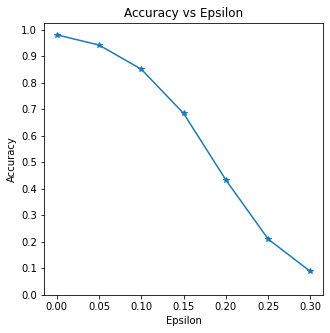

In [9]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

Sample Adversarial Examples
~~~~~~~~~~~~~~~~~~~~~~~~~~~

Remember the idea of no free lunch? In this case, as epsilon increases
the test accuracy decreases **BUT** the perturbations become more easily
perceptible. In reality, there is a tradeoff between accuracy
degredation and perceptibility that an attacker must consider. Here, we
show some examples of successful adversarial examples at each epsilon
value. Each row of the plot shows a different epsilon value. The first
row is the $\epsilon=0$ examples which represent the original
“clean” images with no perturbation. The title of each image shows the
“original classification -> adversarial classification.” Notice, the
perturbations start to become evident at $\epsilon=0.15$ and are
quite evident at $\epsilon=0.3$. However, in all cases humans are
still capable of identifying the correct class despite the added noise.




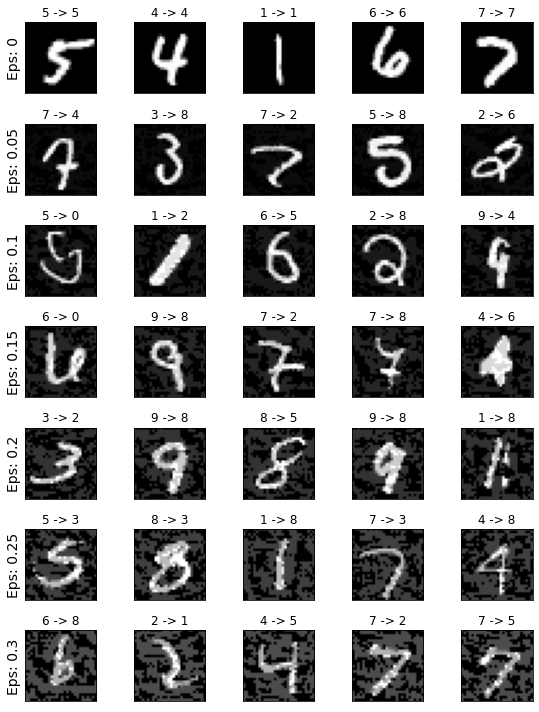

In [10]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

Where to go next?
-----------------

Hopefully this tutorial gives some insight into the topic of adversarial
machine learning. There are many potential directions to go from here.
This attack represents the very beginning of adversarial attack research
and since there have been many subsequent ideas for how to attack and
defend ML models from an adversary. In fact, at NIPS 2017 there was an
adversarial attack and defense competition and many of the methods used
in the competition are described in this paper: `Adversarial Attacks and
Defences Competition <https://arxiv.org/pdf/1804.00097.pdf>`__. The work
on defense also leads into the idea of making machine learning models
more *robust* in general, to both naturally perturbed and adversarially
crafted inputs.

Another direction to go is adversarial attacks and defense in different
domains. Adversarial research is not limited to the image domain, check
out `this <https://arxiv.org/pdf/1801.01944.pdf>`__ attack on
speech-to-text models. But perhaps the best way to learn more about
adversarial machine learning is to get your hands dirty. Try to
implement a different attack from the NIPS 2017 competition, and see how
it differs from FGSM. Then, try to defend the model from your own
attacks.


